[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/drive/1eIwSq_MsOWX8UqDXBpDvKCH41FZY1S3Y?usp=sharing)

# ARIMA model

In [ ]:
%%capture
# !pip install pmdarima # need to load before pandas
!pip install -U statsmodels
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

def mean_absolute_percentage_error(y_true, y_pred):
    epsilon = y_true.copy()
    epsilon = np.where(epsilon==0, np.mean(y_true), epsilon) # in case divide by 0
    mape = np.abs(y_pred - y_true) / np.abs(epsilon)
    output_errors = np.average(mape, axis=0)
    return np.average(output_errors)

## <font color='yellow'>Load</font> input datasets


In [ ]:
with open("/content/drive/Shareddrives/Education/5709_Capstone/proceeded_pickup.pickle", "rb") as f:
    (taxi_green_demand, taxi_yellow_demand, taxi_uber_demand, taxi_lyft_demand, taxi_via_demand) = pickle.load(f)
with open("/content/drive/Shareddrives/Education/5709_Capstone/proceeded_dropoff.pickle", "rb") as f:
    (taxi_green_supply, taxi_yellow_supply, taxi_uber_supply, taxi_lyft_supply, taxi_via_supply) = pickle.load(f)

taxi_demands = [taxi_green_demand, taxi_yellow_demand, taxi_uber_demand, taxi_lyft_demand, taxi_via_demand]
taxi_supplies = [taxi_green_supply, taxi_yellow_supply, taxi_uber_supply, taxi_lyft_supply, taxi_via_supply]
taxi_names = ["green", "yellow", "uber", "lyft", "via"]

_______

## Examinate the data features

Stationarity, Seasonal, Autocorrelation, Partial autocorrelation function, p-value of the model's coefficients


1. ADF :  -19.258911715292577
2. P-Value :  0.0
3. Num Of Lags :  23
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 13224
5. Critical Values :
	 1% :  -3.430844598443207
	 5% :  -2.861758588959801
	 10% :  -2.5668863500012717


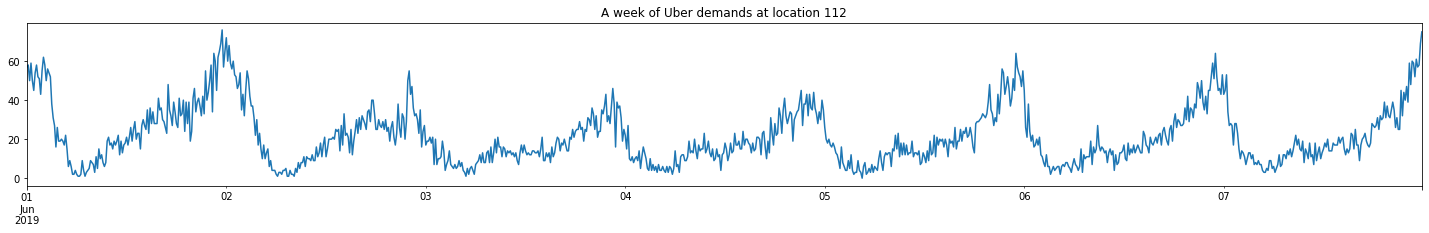

In [ ]:
colNum = 113
oneCycle = 6*24
tmp_series = taxi_uber_demand.iloc[:, colNum]

###########################
# Check For Stationarity
###########################
ax1 = tmp_series[:oneCycle*7].plot(figsize=(25,3), title = 'A week of Uber demands at location '+str(colNum-1))
fig = ax1.get_figure()
fig.savefig("/content/drive/Shareddrives/School_Assignment/5709_Capstone/ARIMA_model/A week of Uber demands at location "+str(colNum-1)+".svg", bbox_inches='tight')

from statsmodels.tsa.stattools import adfuller
def adf_test(dataset):
  dftest = adfuller(dataset, autolag = 'AIC')
  print("1. ADF : ",dftest[0])
  print("2. P-Value : ", dftest[1])
  print("3. Num Of Lags : ", dftest[2])
  print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
  print("5. Critical Values :")
  for key, val in dftest[4].items():
      print("\t",key, ": ", val)
      
adf_test(tmp_series)

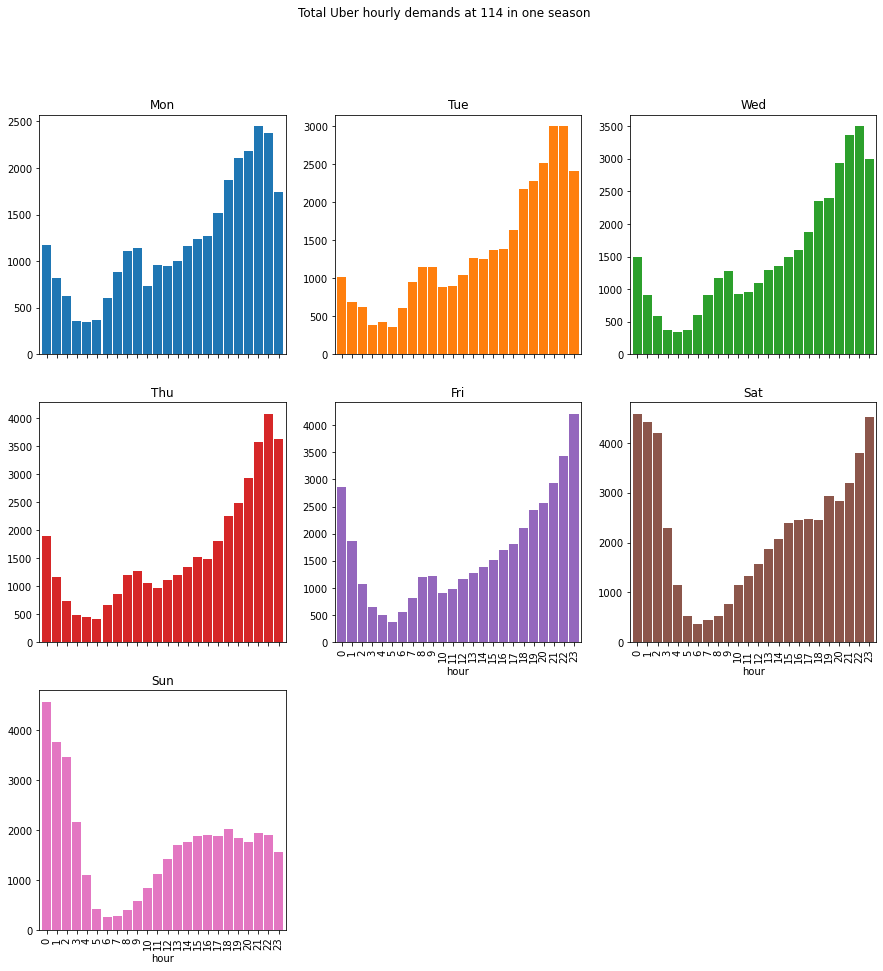

In [ ]:
tmp_df = pd.DataFrame({'PU': tmp_series}).reset_index().rename(columns = {'index': 'PUTime'})
tmp_df['weekNum'] = tmp_df.PUTime.dt.day_name().apply(lambda x: x[0:3])
tmp_df['hour'] = tmp_df.PUTime.dt.hour
each_week_hourly = tmp_df.groupby(['weekNum', 'hour']).agg(sum).unstack(0)

each_week_hourly.columns = each_week_hourly.columns.droplevel()
each_week_hourly = each_week_hourly[['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']]
each_week_hourly.plot.bar(subplots=True, layout=(3, 3), figsize = (15, 15), legend = False, width=0.9, title = 'Total Uber hourly demands at '+str(colNum+1)+" in one season")
plt.savefig('/content/drive/Shareddrives/School_Assignment/5709_Capstone/ARIMA_model/Total Uber hourly demands at '+str(colNum+1)+" in one season.svg", bbox_inches='tight')

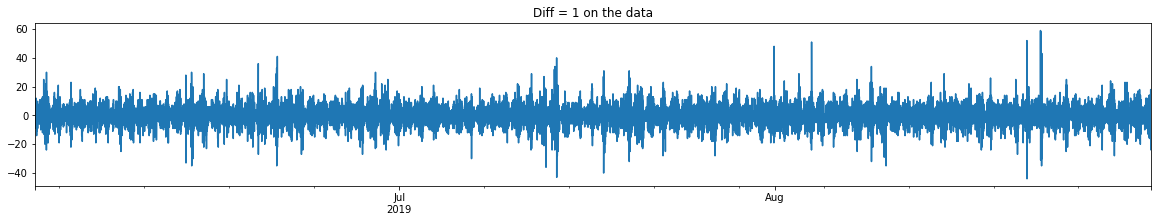

In [ ]:
stationary_df = tmp_series.diff()[1:]
ax1 = stationary_df.plot(figsize=(20,3), title = 'Diff = 1 on the data')
fig = ax1.get_figure()
fig.savefig("/content/drive/Shareddrives/School_Assignment/5709_Capstone/ARIMA_model/Diff = 1 on the data.svg", bbox_inches='tight')

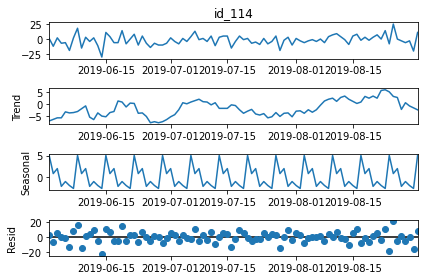

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
fig = seasonal_decompose(stationary_df.asfreq('D'), model='additive', extrapolate_trend='freq').plot();
# fig.suptitle('Seasonality check')
fig.savefig("/content/drive/Shareddrives/School_Assignment/5709_Capstone/ARIMA_model/Seasonality check.svg")

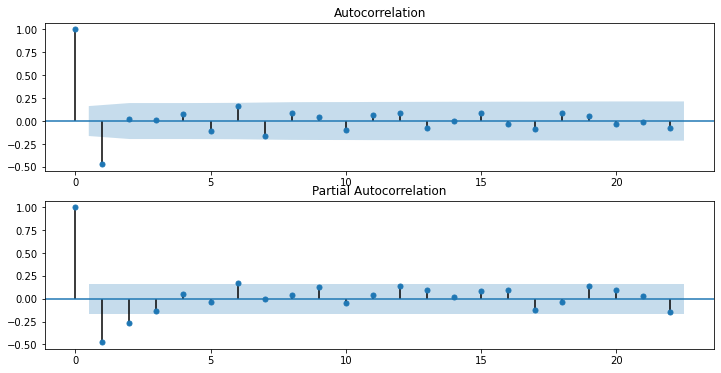

In [ ]:
###########################
# Find the order for ARIMA Model
###########################
# from pmdarima import auto_arima
# print(auto_arima(tmp_series, suppress_warnings=True).summary())


from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
fig = plt.figure(figsize=(12,6));

ax1 = fig.add_subplot(211)
fig1 = plot_acf(stationary_df[:oneCycle], ax = ax1);

ax2 = fig.add_subplot(212)
fig2 = plot_pacf(stationary_df[:oneCycle], ax = ax2);

fig.savefig("/content/drive/Shareddrives/School_Assignment/5709_Capstone/ARIMA_model/ACF_PACF.svg", bbox_inches='tight')

In [ ]:
%%time
# ONLY take the last 7 days to predict next one slot, then rolling forecast.
trainset = tmp_series[:oneCycle*7]
testset = tmp_series[oneCycle*7: oneCycle*14]


# ARIMA_model = SARIMAX(trainset, order=(1,1,4), seasonal_order=(1,0,1,oneCycle)).fit()

ARIMA_model = ARIMA(trainset,order=(1,0,2)).fit()

print(ARIMA_model.summary())

                               SARIMAX Results                                
Dep. Variable:                 id_114   No. Observations:                 1008
Model:                 ARIMA(1, 0, 2)   Log Likelihood               -3177.832
Date:                Mon, 10 May 2021   AIC                           6365.664
Time:                        12:07:06   BIC                           6390.243
Sample:                    06-01-2019   HQIC                          6375.002
                         - 06-07-2019                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         26.1620      5.853      4.470      0.000      14.690      37.634
ar.L1          0.9850      0.007    146.138      0.000       0.972       0.998
ma.L1         -0.5576      0.025    -22.216      0.0

# Train and predict at the same time

We take a week's record to predict the next one time frame. Let $[x_0, x_1, ..., x_n]$ denote the time spectrum of a week, $N=6*24*7=1008$ for a 10min window period, with $[x_0, x_1, ..., x_n]$ we can predict the $x_{n+1}$. 

## Train and predict, then save

Determine which locations to use

In [ ]:
########################################################
#### check for which locations hold most volume    #####
########################################################
multiIndex = pd.MultiIndex.from_product([taxi_names, ['demand', 'supply']], names=["vendor", "feature"])
top_locations_pd = pd.DataFrame(columns=multiIndex)

for i, taxi_name in enumerate(taxi_names):
    top_locations_pd.loc[:, (taxi_name, 'demand')] = taxi_demands[i].sum(axis=0).nlargest().astype(str)\
                                                                .reset_index()\
                                                                .agg(': '.join, axis=1)
    top_locations_pd.loc[:, (taxi_name, 'supply')] = taxi_supplies[i].sum(axis=0).nlargest().astype(str)\
                                                                .reset_index()\
                                                                .agg(': '.join, axis=1)
top_locations_pd

vendor           green                 ...            via               
feature         demand         supply  ...         demand         supply
0        id_74: 115226   id_74: 54450  ...  id_140: 75831  id_161: 92461
1         id_75: 87161   id_42: 49867  ...   id_79: 75772  id_140: 68594
2         id_41: 80122   id_41: 44275  ...  id_236: 72854  id_162: 67018
3         id_82: 64944   id_75: 38474  ...  id_239: 69571  id_236: 66848
4          id_7: 59067  id_129: 36718  ...  id_143: 65695  id_239: 62478

[5 rows x 10 columns]

In [ ]:
%%time

train_split_ratio = 0.65
past = 6*24*7 # 7 days

def arimaPred_Save_and_plot(data_df, colNum, taxi_name, pickup_dropoff):
    tmp_df = data_df.iloc[:, colNum-1] # the col_index starts from 0
    feature = 'demand' if pickup_dropoff =="pickup" else 'supply'

    '''trainset and testset are both one week in length'''
    train_split = int(len(tmp_df)*train_split_ratio)
    trainset = tmp_df[train_split:(train_split+past)]
    # try to make sure the testset starts at the same timestamp as LSTM
    testset = tmp_df[(train_split+past):(train_split+past*2)].rename("True value")

    ARIMA_pred = testset.copy().rename("Predicted value")

    for i in range(len(testset)):
        ARIMA_pred[i] = ARIMA(tmp_df[(train_split+i):(train_split+past+i)],order=(1,0,2))\
                        .fit()\
                        .forecast(1)

    with open("/content/drive/Shareddrives/School_Assignment/5709_Capstone/ARIMA_model/"+pickup_dropoff+"_prediction_"+taxi_name+"_column"+ str(colNum)+".pkl", "wb") as f:
        pickle.dump((ARIMA_pred, testset), f)

########################################################
####                  Predict                      #####
########################################################
colNums = [74, 75, 41, 138, 79, 61, 37]

for i, taxi_name in enumerate(taxi_names):
    arimaPred_Save_and_plot(taxi_demands[i], colNums[0], taxi_name, 'pickup')
    arimaPred_Save_and_plot(taxi_supplies[i], colNums[0], taxi_name, 'dropoff')

CPU times: user 12min 23s, sys: 8min 59s, total: 21min 22s
Wall time: 10min 55s


## <font color='yellow'>Load</font> the evaluation and plot

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: divide by zero encountered in true_divide
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: RuntimeWarning: invalid value encountered in true_divide


'\n\n# this plots each diagram on one figure, better for document organization\nfor i, taxi_name in enumerate(taxi_names):\n    for feature in [\'pickup\', \'dropoff\']:\n        for k, col in enumerate(colNums):\n            plt.figure(figsize=(20,2))\n            ax = plt.gca()\n            pred_target = compute_mape_mse(col, taxi_name, feature)\n            plt.plot(pred_target.index, pred_target[\'Target\'], alpha=0.5, color = \'Gray\', label="Target")\n            plt.plot(pred_target.index, pred_target[\'LSTM_predict\'], label=\'LSTM_predict\')\n            plt.plot(pred_target.index, pred_target[\'ARIMA_predict\'], label=\'ARIMA_predict\')\n            plt.title(r"ARIMA vs LSTM: $\x08f{" + taxi_name + r"}$ taxi $\x08f{" + feature + r"}$")\n            plt.text(0.5, 0.9, "Location "+str(col), horizontalalignment=\'center\', verticalalignment=\'top\',\n                            transform=ax.transAxes, # transform the x-y coordinates to use percentage\n                           

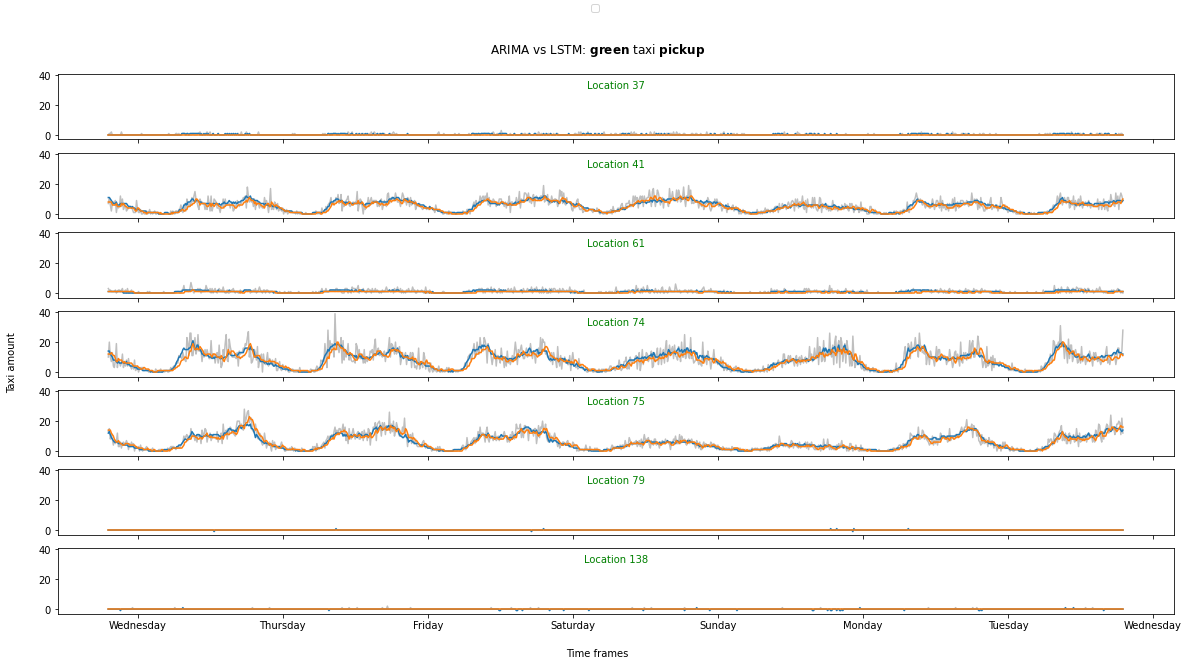

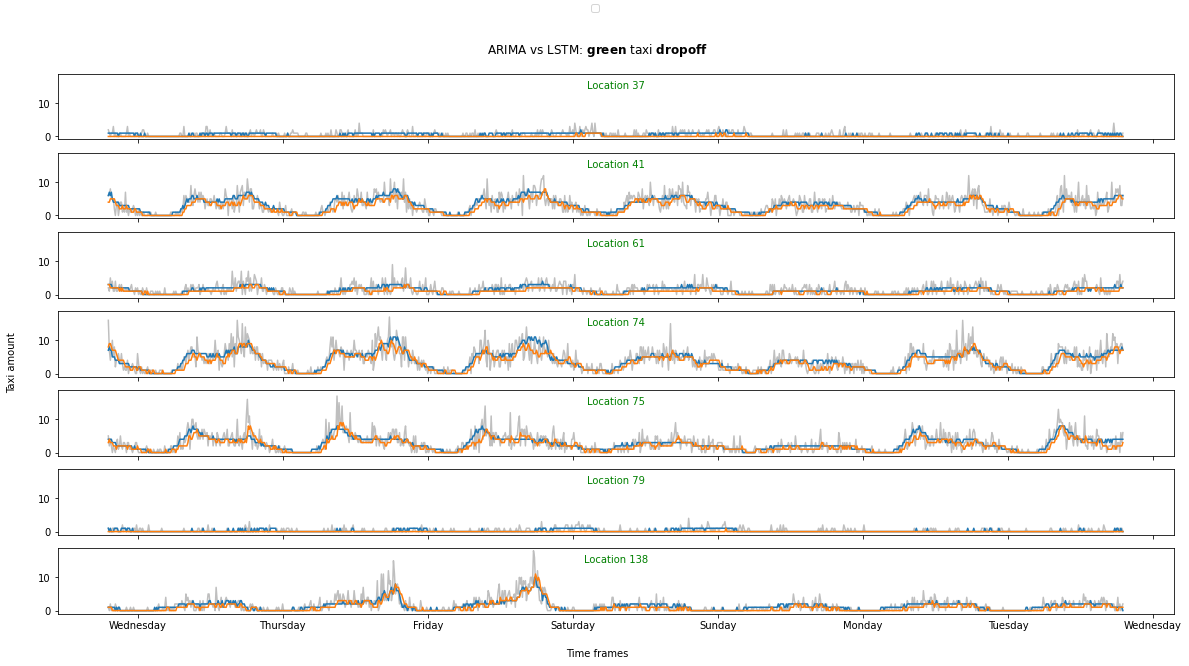

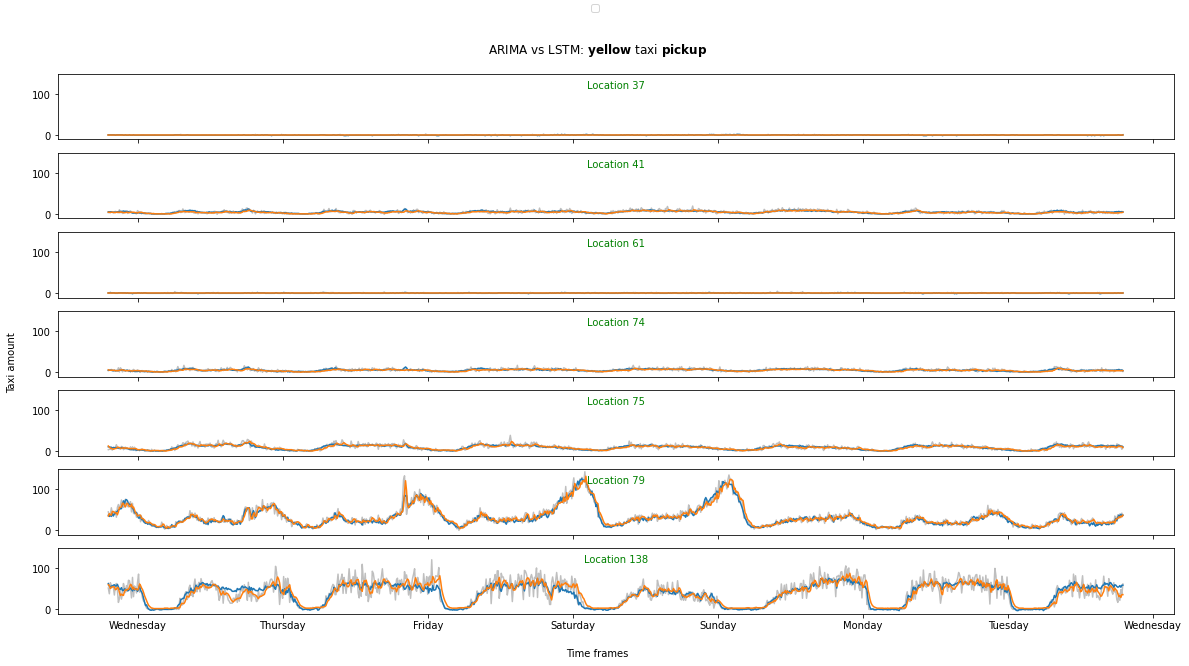

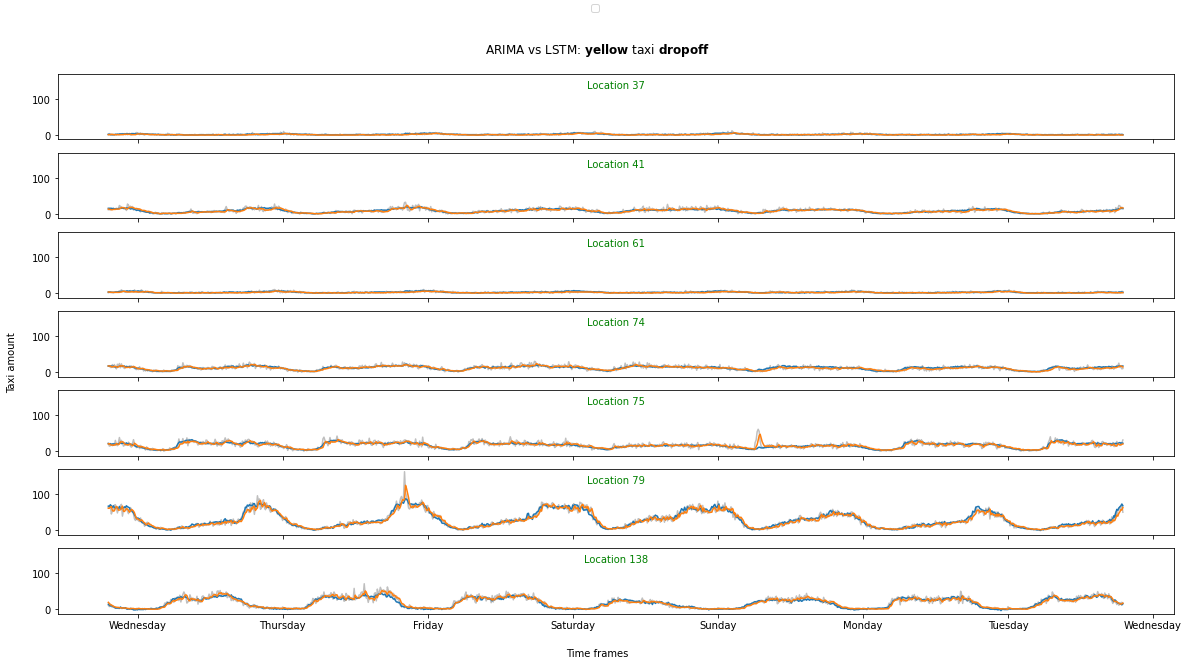

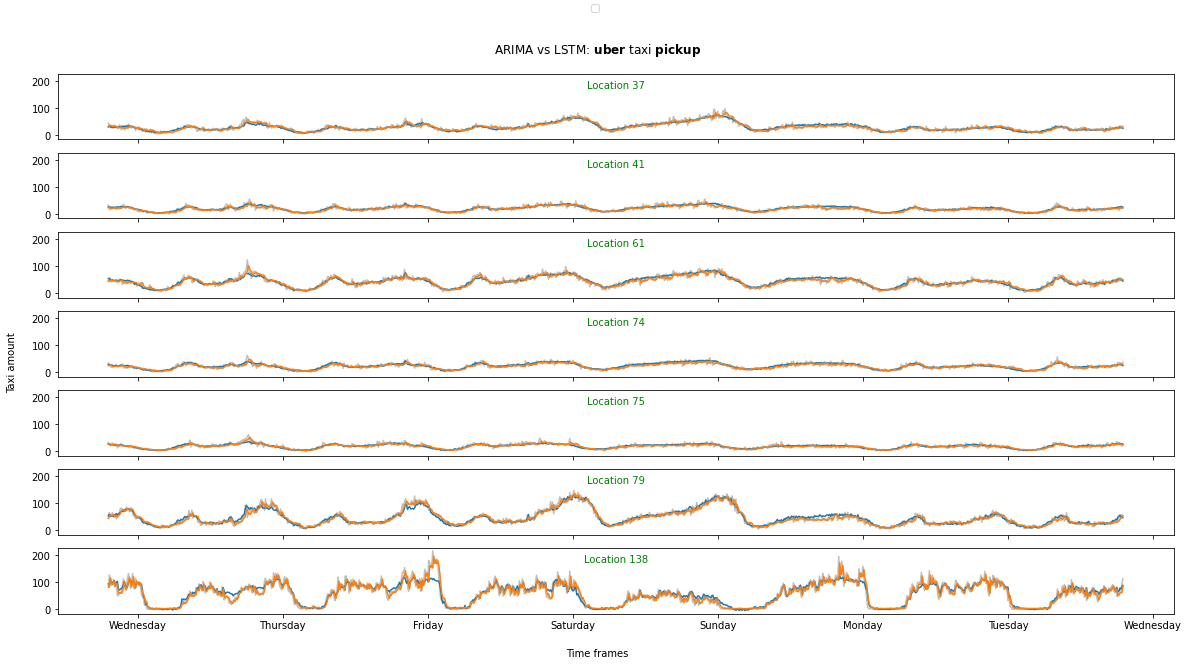

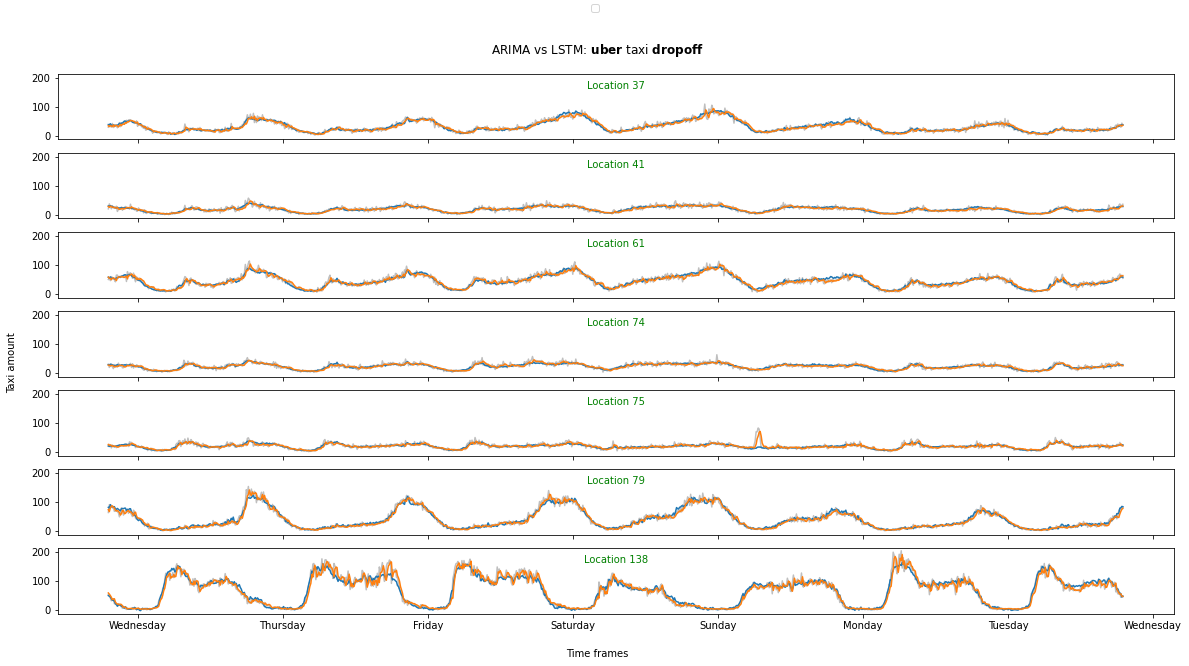

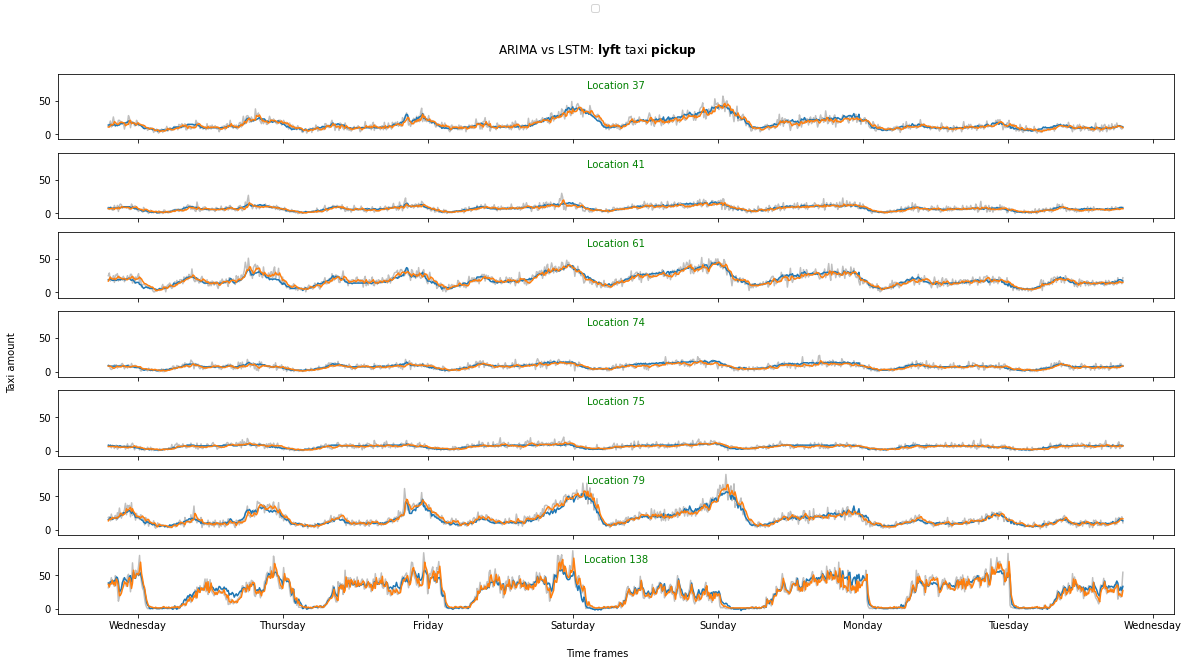

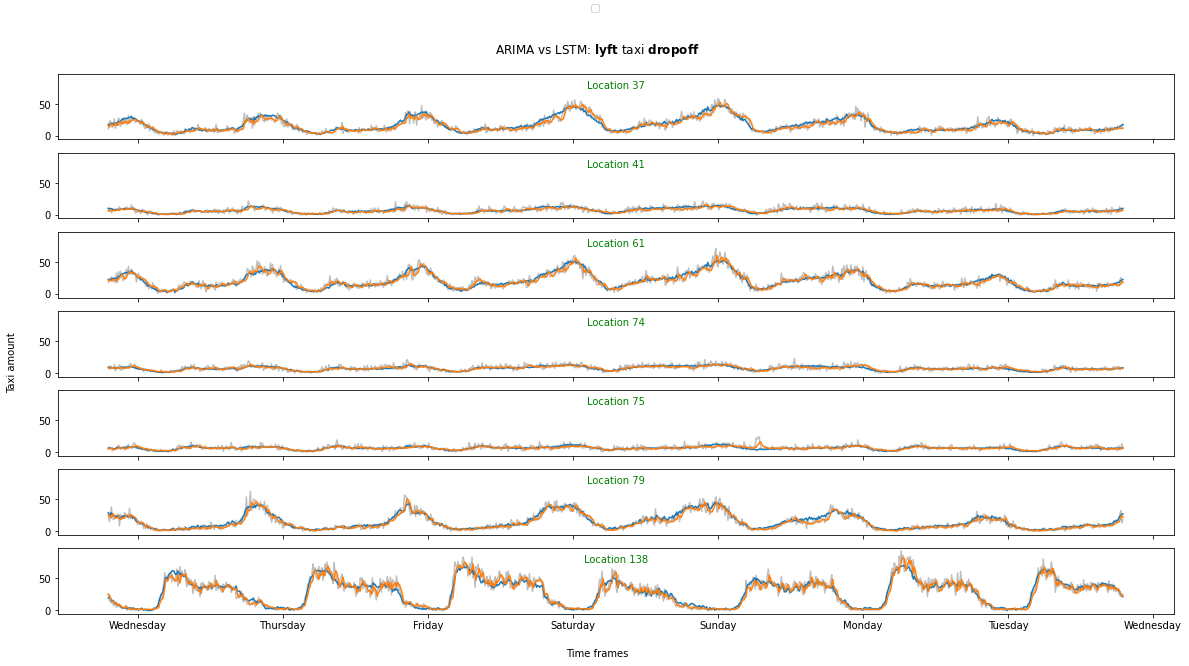

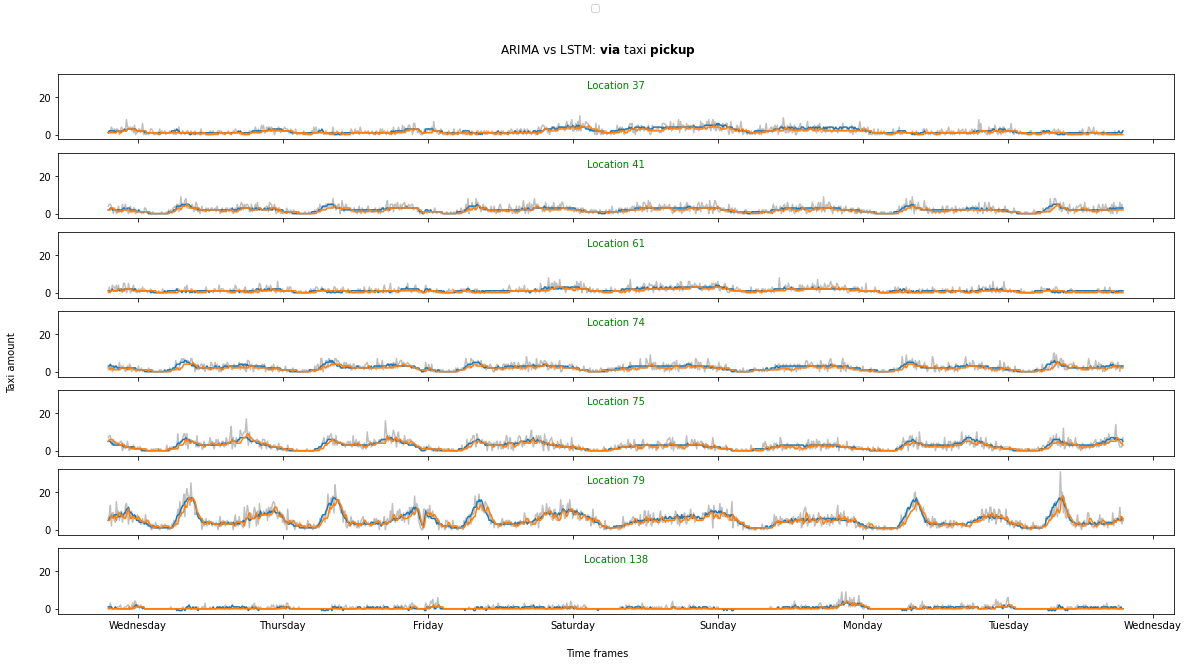

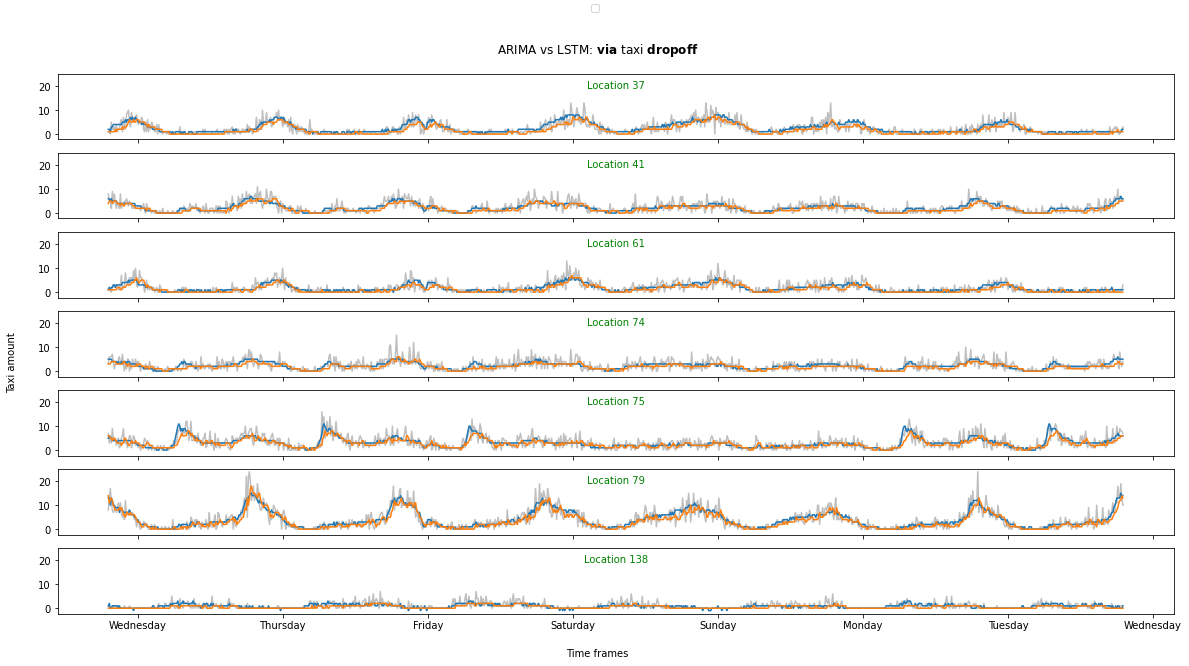

In [ ]:
# plt.style.use('ggplot')
# plt.style.use('default')

def compute_mape_mse(col, taxi_name, pickup_dropoff):
    feature = 'demand' if pickup_dropoff =="pickup" else 'supply'
    # ARIMA
    with open("/content/drive/Shareddrives/School_Assignment/5709_Capstone/ARIMA_model/"+pickup_dropoff+"_prediction_"+taxi_name+"_column"+ str(col)+".pkl", "rb") as f:
        (ARIMA_pred, testset) = pickle.load(f)
        
    ARIMA_model_MSE.loc[(taxi_name, feature, col), 'MAPE'] = mean_absolute_percentage_error(testset, ARIMA_pred)
    ARIMA_model_MSE.loc[(taxi_name, feature, col), 'R2'] = r2_score(testset, ARIMA_pred)
    ARIMA_model_MSE.loc[(taxi_name, feature, col), 'MSE'] = mean_squared_error(testset, ARIMA_pred)

    # LSTM
    with open("/content/drive/Shareddrives/School_Assignment/5709_Capstone/DO-DO, PU-PU, 512_hidden/"+pickup_dropoff+"_prediction_"+taxi_name+".pkl", "rb") as f:
        (pred_all_location, true_all_location) = pickle.load(f)
    LSTM_pred, LSTM_true = pred_all_location[:1008, col-1].round().astype(int), true_all_location[:1008, col-1]
    LSTM_model_MSE.loc[(taxi_name, feature, col), 'MAPE'] = mean_absolute_percentage_error(LSTM_true, LSTM_pred)
    LSTM_model_MSE.loc[(taxi_name, feature, col), 'R2'] = r2_score(LSTM_true, LSTM_pred)
    LSTM_model_MSE.loc[(taxi_name, feature, col), 'MSE'] = mean_squared_error(LSTM_true, LSTM_pred)

    return pd.DataFrame({"ARIMA_predict": ARIMA_pred, "LSTM_predict": LSTM_pred, "Target": testset}, index=testset.index)



########################################################
####                  Evaluation                   #####
########################################################
colNums = [37, 41, 61, 74, 75, 79, 138]

multiIndex = pd.MultiIndex.from_product([taxi_names, ['demand', 'supply'], colNums], names=["vendor", "feature", "location"])
ARIMA_model_MSE = pd.DataFrame(index=multiIndex, columns = ['MAPE','R2','MSE'])
ARIMA_model_MSE = ARIMA_model_MSE.sort_index() # this will get rid of the PerformanceWarning: indexing past lexsort depth may impact performance 

LSTM_model_MSE = ARIMA_model_MSE.copy()

# set xaxis AutoDateFormatter
plt.rcParams["date.autoformatter.day"] = "%A"


'''
# This aggregate all colNums in each subplots in a plt.figure

for i, taxi_name in enumerate(taxi_names):
    for feature in ['pickup', 'dropoff']:
        fig, axs = plt.subplots(len(colNums), sharex=True, sharey=True, figsize=(20, 10))
        fig.subplots_adjust(top=0.9, bottom=0.15) # all subplots topmost at 0.945
        fig.suptitle(r"ARIMA vs LSTM: $\bf{" + taxi_name + r"}$ taxi $\bf{" + feature + r"}$", y=0.945)

        for k, col in enumerate(colNums):
            pred_target = compute_mape_mse(col, taxi_name, feature)

            axs[k].plot(pred_target.index, pred_target['Target'], alpha=0.5, color = 'Gray')
            axs[k].plot(pred_target.index, pred_target[['LSTM_predict', 'ARIMA_predict']])
            # upper middle annotation
            axs[k].text(0.5, 0.9, "Location "+str(col), ha='center', va='top',
                    transform=axs[k].transAxes, # transform the x-y coordinates to use percentage
                    color='green')
        # x label
        fig.text(0.5, 0.09, 'Time frames', ha='center') # colab pyplot default version is 3.2.2, haven't implement figure.supxlabel()
        # y label
        fig.text(0.09, 0.5, 'Taxi amount', va='center', rotation='vertical') # if 3.4.1, we can use figure.supylabel()
        # only take the last one legend
        handles, labels = axs[0].get_legend_handles_labels()
        fig.legend(handles, labels, loc='upper center', ncol = 3)
        # plt.show()
        fig.savefig("/content/drive/Shareddrives/School_Assignment/5709_Capstone/ARIMAvsLSTM/ARIMAvsLSTM_" + taxi_name + "_" + feature + "_ALL.svg", bbox_inches='tight')
'''

# this plots each diagram on one figure, better for document organization
for i, taxi_name in enumerate(taxi_names):
    for feature in ['pickup', 'dropoff']:
        for k, col in enumerate(colNums):
            plt.figure(figsize=(20,2))
            ax = plt.gca()
            pred_target = compute_mape_mse(col, taxi_name, feature)
            plt.plot(pred_target.index, pred_target['Target'], alpha=0.5, color = 'Gray', label="Target")
            plt.plot(pred_target.index, pred_target['LSTM_predict'], label='LSTM_predict')
            plt.plot(pred_target.index, pred_target['ARIMA_predict'], label='ARIMA_predict')
            plt.title(r"ARIMA vs LSTM: $\bf{" + taxi_name + r"}$ taxi $\bf{" + feature + r"}$")
            plt.text(0.5, 0.9, "Location "+str(col), horizontalalignment='center', verticalalignment='top',
                            transform=ax.transAxes, # transform the x-y coordinates to use percentage
                            color='green')
            plt.legend(loc='upper left', ncol=3)
            # plt.show()
            plt.savefig("/content/drive/Shareddrives/School_Assignment/5709_Capstone/ARIMAvsLSTM/ARIMAvsLSTM_" + taxi_name + "_" + feature + "_"+str(col)+".svg", bbox_inches='tight')


ARIMA_model_MSE.to_csv("/content/drive/Shareddrives/School_Assignment/5709_Capstone/ARIMA_model/ARIMA_Evaluation_matrices.csv")
LSTM_model_MSE.to_csv("/content/drive/Shareddrives/School_Assignment/5709_Capstone/ARIMA_model/LSTM_Evaluation_matrices.csv")

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


LSTM:


,MAPE,R2,MSE
0,43.36% ± 20.23%,0.4928 ± 0.4287,26.8958 ± 52.4784


ARIMA:


,MAPE,R2,MSE
0,37.33% ± 10.95%,0.4813 ± 0.3397,29.2496 ± 52.3149


ARIMA better than LSTM:


,MAPE,R2,MSE
0,-0.139033,-0.02329,0.087513


LSTM                           ARIMA            \
                             MAPE        R2         MSE      MAPE        R2   
vendor feature location                                                       
green  demand  37        0.709974 -0.538191    0.399802  0.217262 -0.244294   
               41        0.433559  0.603604    6.312500  0.432879  0.529969   
               61        0.446403  0.125642    1.122024  0.435027 -0.031295   
               74        0.430448  0.640949   14.453373  0.480582  0.542074   
               75        0.354743  0.782340    6.389881  0.373220  0.739186   
               79             NaN  0.000000    0.008929       NaN  1.000000   
               138       1.211971 -1.263341    0.063492  0.025794 -0.025576   
       supply  37        0.649124 -0.110635    0.608135  0.371917 -0.369723   
               41        0.491158  0.527818    3.086310  0.445369  0.427189   
               61        0.488367  0.221726    1.555556  0.444327  0.073318   
               74        0.465580  0.565955    4.499008  0.448227  0.502978   
               75        0.485618  0.507890    3.326389  0.463359  0.396200   
               79        0.529797 -0.138531    0.373016  0.238095 -0.256624   
               138       0.455114  0.508205    2.104167  0.425589  0.426588   
lyft   demand  37        0.270231  0.751962   19.273810  0.287334  0.706193   
               41        0.389678  0.547424    8.975198  0.414769  0.450125   
               61        0.266560  0.748281   23.673611  0.295407  0.716614   
               74        0.439725  0.520454    8.424603  0.441071  0.435635   
               75        0.420360  0.435217    7.059524  0.448476  0.358150   
               79        0.279139  0.825627   27.905754  0.302418  0.811524   
               138       0.402357  0.788556   76.899802  0.396634  0.782839   
       supply  37        0.302223  0.840553   20.839286  0.308109  0.818700   
               41        0.397855  0.590276    8.124008  0.440527  0.508471   
               61        0.238564  0.837951   23.974206  0.282005  0.801265   
               74        0.373280  0.493265    8.652778  0.415543  0.440569   
               75        0.410200  0.321558    8.547619  0.452329  0.283525   
               79        0.427900  0.863092   20.935516  0.381990  0.840749   
               138       0.354049  0.877080   57.836310  0.303564  0.857218   
uber   demand  37        0.190736  0.834260   37.681548  0.195596  0.817346   
               41        0.290148  0.728043   27.279762  0.278273  0.698719   
               61        0.171716  0.839390   56.726190  0.188615  0.812169   
               74        0.262146  0.744363   27.564484  0.263089  0.699106   
               75        0.267864  0.722265   22.125000  0.291414  0.671194   
               79        0.194738  0.901769   81.605159  0.197846  0.895422   
               138       0.601331  0.825537  305.976190  0.495618  0.843154   
       supply  37        0.205065  0.897136   37.464286  0.223662  0.866974   
               41        0.292803  0.765082   23.724206  0.334956  0.703656   
               61        0.161785  0.880803   52.864087  0.185599  0.847001   
               74        0.247307  0.740540   27.053571  0.277438  0.682369   
               75        0.263503  0.558047   39.979167  0.296445  0.585442   
               79        0.295975  0.943771   62.785714  0.270260  0.935334   
               138       0.415798  0.926412  183.427579  0.342934  0.918770   
via    demand  37        0.503810  0.293888    2.185516  0.494452  0.187154   
               41        0.497616  0.320410    2.334325  0.484501  0.143653   
               61        0.462303  0.232451    1.594246  0.480676  0.049997   
               74        0.516470  0.341382    2.407738  0.488909  0.158750   
               75        0.482099  0.490519    3.326389  0.490102  0.353463   
               79        0.438510  0.637918    6.474206  0.496595  0.504593   


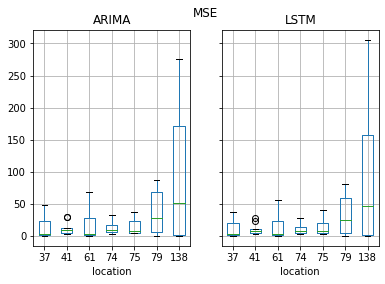

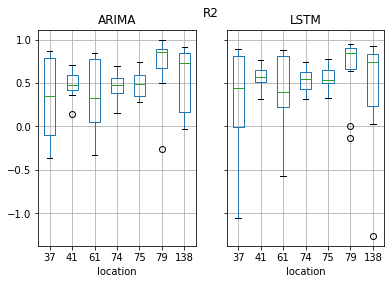

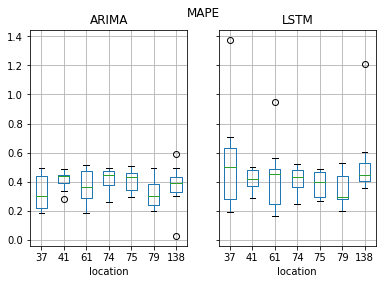

In [ ]:
ARIMA_model_MSE = pd.read_csv("/content/drive/Shareddrives/School_Assignment/5709_Capstone/ARIMA_model/ARIMA_Evaluation_matrices.csv", index_col=[0,1,2])
LSTM_model_MSE = pd.read_csv("/content/drive/Shareddrives/School_Assignment/5709_Capstone/ARIMA_model/LSTM_Evaluation_matrices.csv", index_col=[0,1,2])
combined_matrices = pd.concat([LSTM_model_MSE, ARIMA_model_MSE], axis=1, keys=['LSTM', 'ARIMA'])

# convert multiindex from column to index for grouping
modelName_in_index = combined_matrices.stack(level=0)\
                        .reset_index(level=3)\
                        .rename(columns={'level_3': 'modelName'})\
                        .groupby('modelName')

modelName_in_index.boxplot(by='location', column='MSE')
plt.suptitle('MSE')
plt.savefig("/content/drive/Shareddrives/School_Assignment/5709_Capstone/ARIMA_model/boxplot_MSE.svg")

modelName_in_index.boxplot(by='location', column='R2')
plt.suptitle('R2')
plt.savefig("/content/drive/Shareddrives/School_Assignment/5709_Capstone/ARIMA_model/boxplot_R2.svg")

modelName_in_index.boxplot(by='location', column='MAPE')
plt.suptitle('MAPE')
plt.savefig("/content/drive/Shareddrives/School_Assignment/5709_Capstone/ARIMA_model/boxplot_MAPE.svg")


LSTM_avg = LSTM_model_MSE.agg([np.mean, np.std])
LSTM_avg['MAPE'] = LSTM_avg['MAPE'].apply(lambda x: '{:,.2%}'.format(x))
LSTM_avg[['R2', 'MSE']] = LSTM_avg[['R2', 'MSE']].applymap(lambda x: '{:,.4f}'.format(x))
LSTM_avg = LSTM_avg.applymap(str).apply(' ± '.join, axis = 0)

ARIMA_avg = ARIMA_model_MSE.agg([np.mean, np.std])
ARIMA_avg['MAPE'] = ARIMA_avg['MAPE'].apply(lambda x: '{:,.2%}'.format(x))
ARIMA_avg[['R2', 'MSE']] = ARIMA_avg[['R2', 'MSE']].applymap(lambda x: '{:,.4f}'.format(x))
ARIMA_avg = ARIMA_avg.applymap(str).apply(' ± '.join, axis = 0)

print("LSTM:")
display(pd.DataFrame(LSTM_avg).transpose())
print("ARIMA:")
display(pd.DataFrame(ARIMA_avg).transpose())
print("ARIMA better than LSTM:")
display(pd.DataFrame((ARIMA_model_MSE.mean(axis=0) - LSTM_model_MSE.mean(axis=0))/LSTM_model_MSE.mean(axis=0)).transpose())


with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
    display(combined_matrices)